<a href="https://colab.research.google.com/github/KerongChen/Final-project/blob/main/22043526_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Land Cover and Land Use

## Mounting google drive for dataset access and saving models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [ ]:
!pip install rasterio
!pip install codecarbon
!pip install dash
!pip install dash-bootstrap-components==0.13.1
!pip install netCDF4
!pip install fire
!pip install optuna

import rasterio
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
from datetime import datetime, timedelta
from shapely.geometry import Polygon, Point, shape
import requests
from xml.etree import ElementTree as ET
import json
import folium

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

%matplotlib inline
import random
import optuna
import scipy.stats
import sklearn
import sklearn.ensemble
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import xarray as xr
from codecarbon import EmissionsTracker
from google.colab.output import eval_js
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.6 MB/s eta 0:00:00


## Config

In [ ]:
# Instantiate the tracker object
tracker = EmissionsTracker(
output_dir="/content/drive/MyDrive/GEOL0069/2425/FinalProject/code_carbon/",  # define the directory to which we'll write our emissions results
output_file="emissions.csv",  # define the name of the file containing our emissions results
# log_level='error' # comment out this line to see regular output
)
tracker.start()

def get_access_and_refresh_token(username, password):
      """Retrieve both access and refresh tokens."""
      url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
      data = {
          "grant_type": "password",
          "username": username,
          "password": password,
          "client_id": "cdse-public",
              }
      response = requests.post(url, data=data)
      response.raise_for_status()
      tokens = response.json()
      return tokens["access_token"], tokens["refresh_token"]

def download_single_product(
      product_id, file_name, access_token, download_dir="downloaded_products"
      ):

      # Ensure the download directory exists
      os.makedirs(download_dir, exist_ok=True)

      # Construct the download URL
      url = (
              f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
                  )

      # Set up the session and headers
      headers = {"Authorization": f"Bearer {access_token}"}
      session = requests.Session()
      session.headers.update(headers)

      # Perform the request
      response = session.get(url, headers=headers, stream=True)

      # Check if the request was successful
      if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

      # Stream the content to a file
      with open(output_file_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
          if chunk:
            file.write(chunk)
            print(f"Downloaded: {output_file_path}")
          else:
            print(
                f"Failed to download product {product_id}. Status Code: {response.status_code}")


username = "1364269041@qq.com"
password = "LAZskD4Fx4!P)x]"
access_token, refresh_token = get_access_and_refresh_token(username, password)
path_to_save_data = "/content/drive/MyDrive/GEOL0069/2425/FinalProject/"

ROOT_PATH = '/content/drive/MyDrive/GEOL0069/2425/FinalProject/'
#BASE_PATH = os.path.join(ROOT_PATH, 'Image_Dataset')
BASE_PATH = os.path.join(ROOT_PATH, '2750 2')
DATA_PATH = os.path.join(ROOT_PATH, 'Dataset 2')
FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA2.csv')

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1

## Give idx of each class name
def encode_label(label):
  idx = CLASS_IDX_LABELS[label]
  return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
      return IDX_CLASS_LABELS[target]
    else:
      return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
      fig, ax = plt.subplots(figsize=(16, 8))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
      break


[codecarbon WARNING @ 13:37:45] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:37:45] [setup] RAM Tracking...
[codecarbon INFO @ 13:37:45] [setup] CPU Tracking...
[codecarbon WARNING @ 13:37:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:37:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:37:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:37:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:37:46] [setup] GPU Tracking...
[codecarbon INFO @ 13:37:46] No GPU found.
[codecarbon INFO @ 13:37:46] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

## Data Fetching

In [ ]:
download_dir = "/content/drive/MyDrive/GEOL0069/2425/FinalProject"  # Replace with your desired download directory
product_id = 'e7191897-c4e0-4eb1-babf-c2baabdf4065' # Replace with your desired file id
file_name = 'S2A_MSIL1C_20250403T022131_N0511_R003_T52SCG_20250403T052903.SAFE'# Replace with your desired filename
# Download the single product
download_single_product(product_id, file_name, access_token, download_dir)

[codecarbon INFO @ 13:55:46] Energy consumed for RAM : 0.005999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:55:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:55:46] Energy consumed for All CPU : 0.012748 kWh
[codecarbon INFO @ 13:55:46] 0.018747 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:46] 0.004645 g.CO2eq/s mean an estimation of 146.48716167885306 kg.CO2eq/year
[codecarbon INFO @ 13:55:50] Energy consumed for RAM : 0.012331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:55:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:55:50] Energy consumed for All CPU : 0.026205 kWh
[codecarbon INFO @ 13:55:50] 0.038536 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:01] Energy consumed for RAM : 0.006082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:56:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon

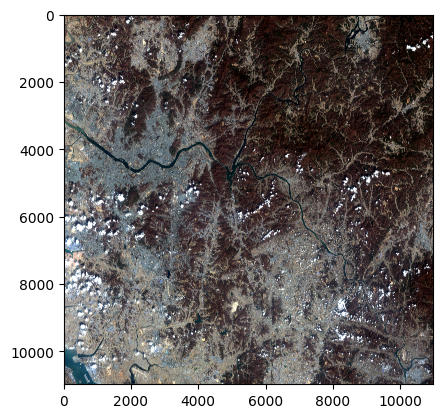

[codecarbon INFO @ 13:56:20] Energy consumed for RAM : 0.012497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:56:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:56:20] Energy consumed for All CPU : 0.026559 kWh
[codecarbon INFO @ 13:56:20] 0.039056 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:31] Energy consumed for RAM : 0.006249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:56:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:56:31] Energy consumed for All CPU : 0.013280 kWh
[codecarbon INFO @ 13:56:31] 0.019528 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:35] Energy consumed for RAM : 0.012581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:56:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:56:35] Energy consumed for All CPU : 0.026736 kWh
[codecarbon INFO @ 13:56:35] 0.039317 kWh 

Image saved as output_rgb_image.png


In [ ]:
# Suppose the path is unzipped as below
red_band_path = '/content/drive/MyDrive/GEOL0069/2425/FinalProject/S2A_MSIL1C_20250403T022131_N0511_R003_T52SCG_20250403T052903.SAFE/GRANULE/L1C_T52SCG_A051080_20250403T022324/IMG_DATA/T52SCG_20250403T022131_B04.jp2'
green_band_path = '/content/drive/MyDrive/GEOL0069/2425/FinalProject/S2A_MSIL1C_20250403T022131_N0511_R003_T52SCG_20250403T052903.SAFE/GRANULE/L1C_T52SCG_A051080_20250403T022324/IMG_DATA/T52SCG_20250403T022131_B03.jp2'
blue_band_path = '/content/drive/MyDrive/GEOL0069/2425/FinalProject/S2A_MSIL1C_20250403T022131_N0511_R003_T52SCG_20250403T052903.SAFE/GRANULE/L1C_T52SCG_A051080_20250403T022324/IMG_DATA/T52SCG_20250403T022131_B02.jp2'

with rasterio.open(red_band_path) as red_src, \
     rasterio.open(green_band_path) as green_src, \
     rasterio.open(blue_band_path) as blue_src:

# read the band data and show
    red = red_src.read(1)
    green = green_src.read(1)
    blue = blue_src.read(1)

def normalize_percentile(array, lower_percentile=2, upper_percentile=98):
      p_lo, p_hi = np.percentile(array, (lower_percentile, upper_percentile))
      array_clipped = np.clip(array, p_lo, p_hi)
      return (array_clipped - p_lo) / (p_hi - p_lo)

red_normalized = normalize_percentile(red)
green_normalized = normalize_percentile(green)
blue_normalized = normalize_percentile(blue)

rgb_image_normalized = np.stack((red_normalized, green_normalized, blue_normalized), axis=0)

show(rgb_image_normalized)
import matplotlib.pyplot as plt
rgb_image_normalized = np.stack((red_normalized, green_normalized, blue_normalized), axis=2)
plt.imsave('/content/drive/MyDrive/GEOL0069/2425/FinalProject/output_rgb_image.png', rgb_image_normalized)
print("Image saved as output_rgb_image.png")

##Photo Cropping

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/drive/MyDrive/GEOL0069/2425/FinalProject/output_rgb_image.png')
height, width, _ = img.shape

# size to crop
crop_size = 2240

start_x = 0
start_y = height - crop_size

# [start_y:start_y + crop_size, start_x:start_x + crop_size]
cropped_image = img[start_y:start_y + crop_size, start_x:start_x + crop_size]

# save the photo
plt.imsave('/content/drive/MyDrive/GEOL0069/2425/FinalProject/output_rgb_image_cutted2240.jpg', cropped_image)
print("Cropped image saved as output_cropped_image.png")

[codecarbon INFO @ 15:20:16] Energy consumed for RAM : 0.034157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:20:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:20:16] Energy consumed for All CPU : 0.072593 kWh
[codecarbon INFO @ 15:20:16] 0.106749 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:20:21] Energy consumed for RAM : 0.040489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:20:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:20:21] Energy consumed for All CPU : 0.086050 kWh
[codecarbon INFO @ 15:20:21] 0.126539 kWh of electricity used since the beginning.


Cropped image saved as output_cropped_image.png


#K-means Learning Method

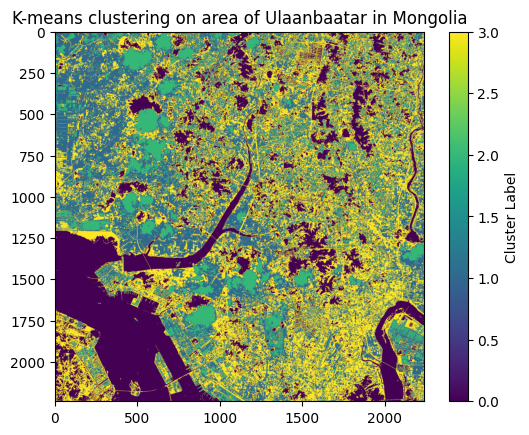

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Read  images
img_path  = '/content/drive/MyDrive/GEOL0069/2425/FinalProject/output_rgb_image_cutted2240.jpg'
img_raw   = Image.open(img_path)

#convert to numpy array
img_np    = np.array(img_raw)
height, width, channels = img_np.shape
X = img_np.reshape((height * width, channels))

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
#labels = kmeans.labels_
labels = kmeans.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
#labels_image = np.full(band_stack.shape[:2], -1, dtype=int)
labels_image = labels.reshape((height,width))

# Place cluster labels in the locations corresponding to valid data
#labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('K-means clustering on area of Ulaanbaatar in Mongolia')
plt.colorbar(label='Cluster Label')
plt.show()

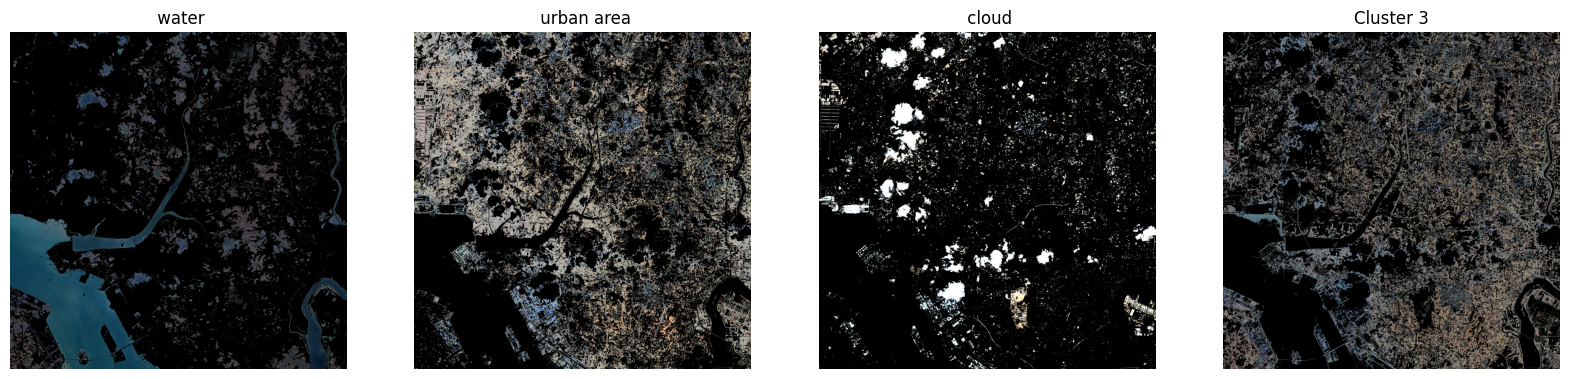

[codecarbon INFO @ 14:28:36] Energy consumed for RAM : 0.023245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:28:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:28:36] Energy consumed for All CPU : 0.049400 kWh
[codecarbon INFO @ 14:28:36] 0.072645 kWh of electricity used since the beginning.


In [ ]:
clusters_img_dict = {}
fig, axes = plt.subplots(1, kmeans.n_clusters, figsize=(20, 5))
array = ["water","urban area","cloud","forest"]
for i in range(kmeans.n_clusters):

    mask = (labels_image == i)
    mask_3d = np.stack([mask]*3, axis=2)
    img_array = np.array(Image.open(img_path))

    segmented_image = np.copy(img_array)
    segmented_image[~mask_3d] = 0  # set the other class as blace

    clusters_img_dict[f'Cluster_{i}'] = segmented_image

    ax=axes[i]
    ax.imshow(segmented_image)
    ax.axis('off')
    ax.set_title(f' {array[i]}')

ax.axis('off')
ax.set_title(f'Cluster {i}')

plt.show()

for name, img in clusters_img_dict.items():
    output_img = Image.fromarray(img)
    output_img.save(f'/content/drive/MyDrive/GEOL0069/2425/FinalProject/{name}.png')

[codecarbon INFO @ 15:18:31] Energy consumed for RAM : 0.033574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:18:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:18:31] Energy consumed for All CPU : 0.071353 kWh
[codecarbon INFO @ 15:18:31] 0.104927 kWh of electricity used since the beginning.


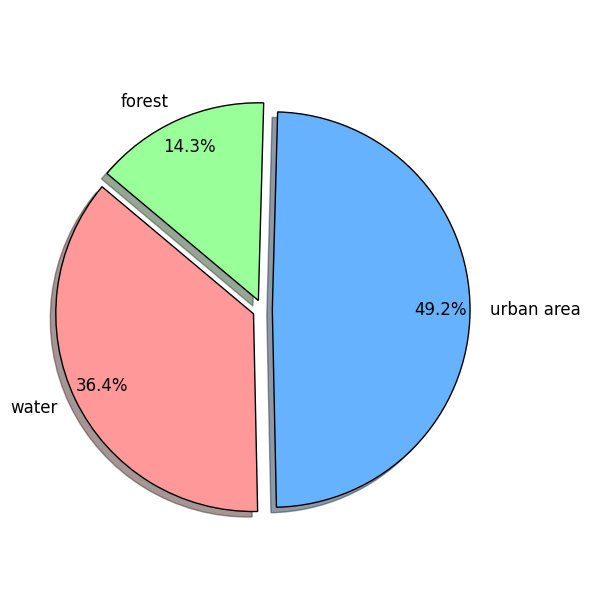

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
labelss = ['water', 'urban area', 'forest']
labelsss =[0,1,3]
pixels_sum = sum(cluster_sizes.get(k, 0) for k in labelsss)


cluster_percentages = {k: v / pixels_sum  for k, v in cluster_sizes.items()}
sizes = [cluster_percentages[0],cluster_percentages[1],cluster_percentages[2]]
#sizes = [cluster_sizes['water'],cluster_sizes['forest'],cluster_sizes['urban area']]
explode = (0.05, 0.05, 0.05)

colors = ['#ff9999','#66b2ff','#99ff99']

cdict = {'red':   [[0.0,  1.0, 1.0],[1.0,  0.0, 0.0]],
'green': [[0.0,  0.0, 0.0],[1.0,  1.0, 1.0]],
'blue':  [[0.0,  0.0, 0.0],[1.0,  0.0, 0.0]]}
gradient_cmap = LinearSegmentedColormap('gradient', segmentdata=cdict, N=256)

plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labelss, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140,pctdistance=0.85, textprops={'fontsize': 12, 'color': 'black'},wedgeprops={'edgecolor': 'black'})
plt.title(' ', fontsize=16, color='darkblue')
plt.axis('equal')
plt.tight_layout()

plt.show()

##Supervised learning

## Pre-Processing data folders to train and test

In [ ]:
from os import walk
i = 0
for (dirpath, dirname, filename) in walk(BASE_PATH):
  print("Directory Path: ", dirpath)
  print("Directory Name: ", dirname)
  print("Filename : ", filename)
  print("----------------------"*10)
  i += 1
  if i > 3:
    break

Directory Path:  /content/drive/MyDrive/GEOL0069/2425/FinalProject/2750 2
Directory Name:  ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'SeaLake', 'Pasture', 'Residential', 'Highway', 'River', 'PermanentCrop']
Filename :  []
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Directory Path:  /content/drive/MyDrive/GEOL0069/2425/FinalProject/2750 2/Forest
Directory Name:  []
Filename :  ['Forest_28.jpg', 'Forest_26.jpg', 'Forest_21.jpg', 'Forest_14.jpg', 'Forest_13.jpg', 'Forest_30.jpg', 'Forest_1.jpg', 'Forest_37.jpg', 'Forest_6.jpg', 'Forest_45.jpg', 'Forest_39.jpg', 'Forest_8.jpg', 'Forest_42.jpg', 'Forest_12.jpg', 'Forest_15.jpg', 'Forest_20.jpg', 'Forest_27.jpg', 'Forest_29.jpg', 'Forest_43.jpg', 'Forest_44.jpg', 'Forest_38.jpg', 'Forest_9.jpg', 'Forest_36.jpg', 'Forest_7.jpg', 'Forest_31.jpg', 'F

In [ ]:
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label'])

for (dirpath, dirname, filename) in walk(BASE_PATH):
  for each_file in filename:
    DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
    i += 1
  # break
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()


,image_id,label
0,Forest_28.jpg,Forest
1,Forest_26.jpg,Forest
2,Forest_21.jpg,Forest
3,Forest_14.jpg,Forest
4,Forest_13.jpg,Forest


## Processing data folders to train and test


In [ ]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48)
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [ ]:
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id.split('.')[0].split('_')[0], img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [ ]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSAT(VALID_DF, BASE_PATH, data_transform)
print(len(train_ds), len(valid_ds))

450 50


[codecarbon INFO @ 14:34:51] Energy consumed for RAM : 0.025328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:34:51] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 14:34:51] Energy consumed for All CPU : 0.053827 kWh
[codecarbon INFO @ 14:34:51] 0.079155 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:34:51] 0.004644 g.CO2eq/s mean an estimation of 146.4674821687042 kg.CO2eq/year
[codecarbon INFO @ 14:35:01] Energy consumed for RAM : 0.019079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:35:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:35:01] Energy consumed for All CPU : 0.040547 kWh
[codecarbon INFO @ 14:35:01] 0.059626 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:35:06] Energy consumed for RAM : 0.025411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:35:06] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon 

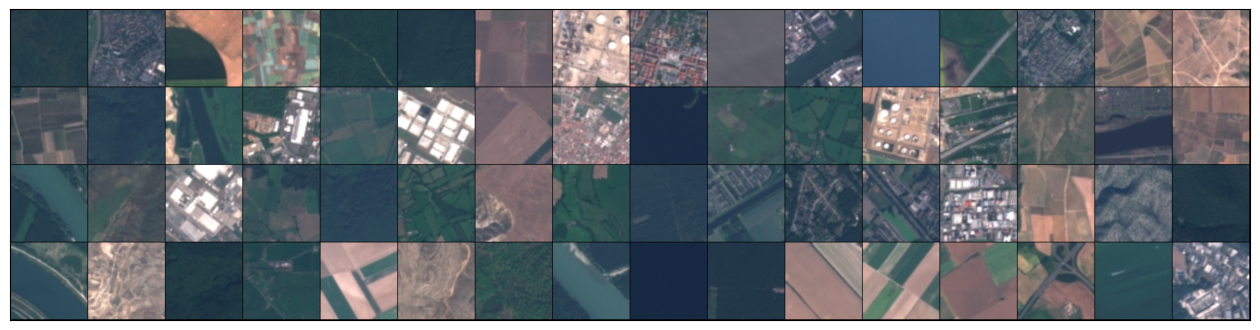

In [ ]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):

    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}

    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)

    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:
model = LULC_Model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 124MB/s]
[codecarbon INFO @ 14:35:46] Energy consumed for RAM : 0.019329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:35:46] Delta energy consumed for CPU with constant : 0.0

In [ ]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)

[codecarbon INFO @ 14:35:51] Energy consumed for RAM : 0.025661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:35:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:35:51] Energy consumed for All CPU : 0.054535 kWh
[codecarbon INFO @ 14:35:51] 0.080196 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:01] Energy consumed for RAM : 0.019412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:36:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:36:01] Energy consumed for All CPU : 0.041255 kWh
[codecarbon INFO @ 14:36:01] 0.060667 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:06] Energy consumed for RAM : 0.025744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:36:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:36:06] Energy consumed for All CPU : 0.054712 kWh
[codecarbon INFO @ 14:36:06] 0.080456 kWh 

torch.Size([64, 3, 224, 224])


[codecarbon INFO @ 14:36:16] Energy consumed for RAM : 0.019495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:36:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:36:16] Energy consumed for All CPU : 0.041432 kWh
[codecarbon INFO @ 14:36:16] 0.060927 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:21] Energy consumed for RAM : 0.025827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:36:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:36:21] Energy consumed for All CPU : 0.054889 kWh
[codecarbon INFO @ 14:36:21] 0.080717 kWh of electricity used since the beginning.


torch.Size([64, 10])
tensor([-2.2994, -2.4626, -2.4859, -2.0194, -2.2662, -2.1224, -2.2537, -2.4859,
        -2.3681, -2.3740], grad_fn=<SelectBackward0>)


[codecarbon INFO @ 14:36:31] Energy consumed for RAM : 0.019579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:36:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:36:31] Energy consumed for All CPU : 0.041609 kWh
[codecarbon INFO @ 14:36:31] 0.061188 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:36] Energy consumed for RAM : 0.025911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:36:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:36:36] Energy consumed for All CPU : 0.055066 kWh
[codecarbon INFO @ 14:36:36] 0.080977 kWh of electricity used since the beginning.


## Training and Evaluating

In [ ]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):

    history = []
    #valid_loss_min = np.Inf
    valid_loss_min = np.inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)

    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):

            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))



        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history

        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device¶


In [ ]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

False


[codecarbon INFO @ 14:38:16] Energy consumed for RAM : 0.020162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:38:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:38:16] Energy consumed for All CPU : 0.042849 kWh
[codecarbon INFO @ 14:38:16] 0.063010 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:38:21] Energy consumed for RAM : 0.026494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:38:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:38:21] Energy consumed for All CPU : 0.056306 kWh
[codecarbon INFO @ 14:38:21] 0.082800 kWh of electricity used since the beginning.


torch.Size([64, 3, 224, 224])


[codecarbon INFO @ 14:38:31] Energy consumed for RAM : 0.020245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:38:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:38:31] Energy consumed for All CPU : 0.043026 kWh
[codecarbon INFO @ 14:38:31] 0.063271 kWh of electricity used since the beginning.


torch.Size([64, 10])
tensor([-2.2501, -2.4086, -2.2859, -2.1107, -2.4517, -2.2919, -2.3374, -2.6733,
        -2.2643, -2.0785], grad_fn=<SelectBackward0>)


In [ ]:
torch.cuda.empty_cache()

## Training

In [ ]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 10
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

[codecarbon INFO @ 14:39:01] Energy consumed for RAM : 0.020412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:39:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:39:01] Energy consumed for All CPU : 0.043380 kWh
[codecarbon INFO @ 14:39:01] 0.063792 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:06] Energy consumed for RAM : 0.026744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:39:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:39:06] Energy consumed for All CPU : 0.056837 kWh
[codecarbon INFO @ 14:39:06] 0.083581 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:16] Energy consumed for RAM : 0.020495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:39:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:39:16] Energy consumed for All CPU : 0.043557 kWh
[codecarbon INFO @ 14:39:16] 0.064052 kWh 

{'val_loss': 2.3094706535339355, 'val_acc': 0.11999999731779099}

In [ ]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 14:39:46] Energy consumed for RAM : 0.020662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:39:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:39:46] Energy consumed for All CPU : 0.043911 kWh
[codecarbon INFO @ 14:39:46] 0.064573 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:46] 0.004645 g.CO2eq/s mean an estimation of 146.4834206525711 kg.CO2eq/year
[codecarbon INFO @ 14:39:51] Energy consumed for RAM : 0.026994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:39:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:39:51] Energy consumed for All CPU : 0.057368 kWh
[codecarbon INFO @ 14:39:51] 0.084362 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:40:01] Energy consumed for RAM : 0.020745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:40:01] Delta energy consumed for CPU with constant : 0.00

Epoch [0],train_accu: 0.4434, learning_rate: 0.0001, train_loss: 2.1020, val_loss: 2.1550, val_acc: 0.2200


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 14:44:01] Energy consumed for RAM : 0.022078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:44:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:44:01] Energy consumed for All CPU : 0.046921 kWh
[codecarbon INFO @ 14:44:01] 0.068999 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:44:06] Energy consumed for RAM : 0.028410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:44:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:44:06] Energy consumed for All CPU : 0.060378 kWh
[codecarbon INFO @ 14:44:06] 0.088788 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:44:16] Energy consumed for RAM : 0.022161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:44:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:44:16] Energy consumed for All CPU : 0.047098 kWh
[code

Epoch [1],train_accu: 0.7285, learning_rate: 0.0001, train_loss: 1.5672, val_loss: 1.7680, val_acc: 0.4400


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 14:47:46] Energy consumed for RAM : 0.023327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:47:46] Energy consumed for All CPU : 0.049576 kWh
[codecarbon INFO @ 14:47:46] 0.072904 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:47:46] 0.004645 g.CO2eq/s mean an estimation of 146.48285264193333 kg.CO2eq/year
[codecarbon INFO @ 14:47:51] Energy consumed for RAM : 0.029660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:47:51] Energy consumed for All CPU : 0.063034 kWh
[codecarbon INFO @ 14:47:51] 0.092694 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:48:01] Energy consumed for RAM : 0.023411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:01] Delta energy consumed for CPU with constant : 0.0

Epoch [2],train_accu: 0.7969, learning_rate: 0.0001, train_loss: 1.0789, val_loss: 1.4326, val_acc: 0.5400


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 14:51:31] Energy consumed for RAM : 0.024577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:51:31] Energy consumed for All CPU : 0.052232 kWh
[codecarbon INFO @ 14:51:31] 0.076809 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:36] Energy consumed for RAM : 0.030909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:51:36] Energy consumed for All CPU : 0.065690 kWh
[codecarbon INFO @ 14:51:36] 0.096599 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:46] Energy consumed for RAM : 0.024660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:51:46] Energy consumed for All CPU : 0.052409 kWh
[code

Epoch [3],train_accu: 0.8418, learning_rate: 0.0001, train_loss: 0.8079, val_loss: 1.1728, val_acc: 0.6000


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 14:55:21] Energy consumed for RAM : 0.032159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:55:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:55:21] Energy consumed for All CPU : 0.068345 kWh
[codecarbon INFO @ 14:55:21] 0.100504 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:31] Energy consumed for RAM : 0.025910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:55:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:55:31] Energy consumed for All CPU : 0.055065 kWh
[codecarbon INFO @ 14:55:31] 0.080974 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:36] Energy consumed for RAM : 0.032242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:55:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:55:36] Energy consumed for All CPU : 0.068522 kWh
[code

Epoch [4],train_accu: 0.8652, learning_rate: 0.0001, train_loss: 0.4839, val_loss: 0.7603, val_acc: 0.8400


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 14:59:01] Energy consumed for RAM : 0.027076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:59:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:01] Energy consumed for All CPU : 0.057543 kWh
[codecarbon INFO @ 14:59:01] 0.084619 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:06] Energy consumed for RAM : 0.033409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:59:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:06] Energy consumed for All CPU : 0.071001 kWh
[codecarbon INFO @ 14:59:06] 0.104410 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:16] Energy consumed for RAM : 0.027159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:59:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:16] Energy consumed for All CPU : 0.057720 kWh
[code

Epoch [5],train_accu: 0.8730, learning_rate: 0.0001, train_loss: 0.3339, val_loss: 0.4503, val_acc: 0.9400


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 15:02:46] Energy consumed for RAM : 0.028326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:02:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:02:46] Energy consumed for All CPU : 0.060199 kWh
[codecarbon INFO @ 15:02:46] 0.088525 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:51] Energy consumed for RAM : 0.034658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:02:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:02:51] Energy consumed for All CPU : 0.073657 kWh
[codecarbon INFO @ 15:02:51] 0.108315 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:51] 0.004645 g.CO2eq/s mean an estimation of 146.47488870173865 kg.CO2eq/year
[codecarbon INFO @ 15:03:01] Energy consumed for RAM : 0.028409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:03:01] Delta energy consumed for CPU with constant : 0.0

Epoch [6],train_accu: 0.8672, learning_rate: 0.0001, train_loss: 0.4295, val_loss: 0.4147, val_acc: 0.9200


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 15:07:01] Energy consumed for RAM : 0.029742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:07:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:01] Energy consumed for All CPU : 0.063209 kWh
[codecarbon INFO @ 15:07:01] 0.092950 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:06] Energy consumed for RAM : 0.036074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:07:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:06] Energy consumed for All CPU : 0.076666 kWh
[codecarbon INFO @ 15:07:06] 0.112740 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:16] Energy consumed for RAM : 0.029825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:07:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:16] Energy consumed for All CPU : 0.063386 kWh
[code

Epoch [7],train_accu: 0.9297, learning_rate: 0.0001, train_loss: 0.3027, val_loss: 0.5485, val_acc: 0.8600


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 15:10:31] Energy consumed for RAM : 0.030908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:10:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:10:31] Energy consumed for All CPU : 0.065687 kWh
[codecarbon INFO @ 15:10:31] 0.096595 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:36] Energy consumed for RAM : 0.037240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:10:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:10:36] Energy consumed for All CPU : 0.079145 kWh
[codecarbon INFO @ 15:10:36] 0.116385 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:46] Energy consumed for RAM : 0.030991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:10:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:10:46] Energy consumed for All CPU : 0.065864 kWh
[code

Epoch [8],train_accu: 0.9277, learning_rate: 0.0001, train_loss: 0.3270, val_loss: 0.8268, val_acc: 0.7600


  0%|          | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 15:14:16] Energy consumed for RAM : 0.032157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:14:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:14:16] Energy consumed for All CPU : 0.068343 kWh
[codecarbon INFO @ 15:14:16] 0.100500 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:21] Energy consumed for RAM : 0.038490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:14:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:14:21] Energy consumed for All CPU : 0.081801 kWh
[codecarbon INFO @ 15:14:21] 0.120291 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:31] Energy consumed for RAM : 0.032241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:14:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:14:31] Energy consumed for All CPU : 0.068520 kWh
[code

Epoch [9],train_accu: 0.9355, learning_rate: 0.0001, train_loss: 0.2218, val_loss: 0.5487, val_acc: 0.8200
VAL LOSS MIN 0.4146515130996704
VAL ACC MAX 0.9399999976158142


## Grid segmentation and evaluation on whole dataset

In [ ]:
from PIL import Image
import os
from tqdm import tqdm
from collections import Counter
import torchvision.transforms as transforms
import torch

def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return int(prediction)

target_digits = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
digit_counter = Counter()

patch_size=(224,224)
image_path = '/content/drive/MyDrive/GEOL0069/2425/FinalProject/output_rgb_image_cutted2240.jpg'
img = Image.open(image_path)
width, height = img.size

rows = (height + patch_size[1] - 1) // patch_size[1]
cols = (width + patch_size[0] - 1) // patch_size[0]
total_patches = cols * rows

transform = transforms.ToTensor()

patch_num = 0
with tqdm(total=total_patches, desc='Processing patches', unit='patch') as pbar:
  for row in range(rows):
    for col in range(cols):
        left = col * patch_size[0]
        upper = row * patch_size[1]
        right = min((col + 1) * patch_size[0], width)
        lower = min((row + 1) * patch_size[1], height)
        box = (left, upper, right, lower)
        patch = img.crop(box)
        tensor_image = transform(patch)

        if right - left == patch_size[0] and lower - upper == patch_size[1]:
          digit = predict_single(tensor_image)
          if digit in target_digits:
              digit_counter[digit] += 1
        pbar.update(1)




Processing patches:  46%|████▌     | 46/100 [00:08<00:08,  6.57patch/s][codecarbon INFO @ 15:35:01] Energy consumed for RAM : 0.039072 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:35:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:01] Energy consumed for All CPU : 0.083039 kWh
[codecarbon INFO @ 15:35:01] 0.122111 kWh of electricity used since the beginning.
Processing patches:  72%|███████▏  | 72/100 [00:12<00:04,  6.55patch/s][codecarbon INFO @ 15:35:06] Energy consumed for RAM : 0.045405 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:35:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:06] Energy consumed for All CPU : 0.096496 kWh
[codecarbon INFO @ 15:35:06] 0.141901 kWh of electricity used since the beginning.
Processing patches: 100%|██████████| 100/100 [00:17<00:00,  5.74patch/s]


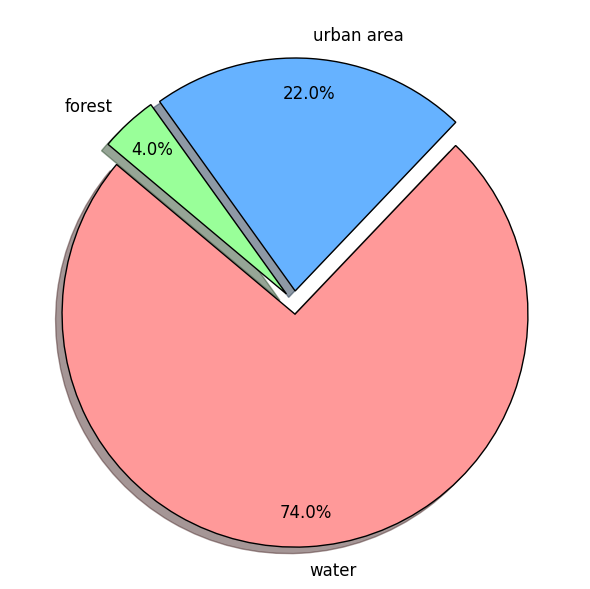

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

target_digits0 = [8,9]
selected_total0 = sum(digit_counter.get(d, 0) for d in target_digits0)

target_digits1 = [3,4,7]
selected_total1 = sum(digit_counter.get(d, 0) for d in target_digits1)

target_digits3 = [0, 1, 2, 5, 6]
selected_total3 = sum(digit_counter.get(d, 0) for d in target_digits3)
total = selected_total0+selected_total1+selected_total3

sizes = [selected_total0/total,selected_total1/total,selected_total3/total]

explode = (0.05, 0.05, 0.05)

colors = ['#ff9999','#66b2ff','#99ff99']

cdict = {'red':   [[0.0,  1.0, 1.0],[1.0,  0.0, 0.0]],
'green': [[0.0,  0.0, 0.0],[1.0,  1.0, 1.0]],
'blue':  [[0.0,  0.0, 0.0],[1.0,  0.0, 0.0]]}
gradient_cmap = LinearSegmentedColormap('gradient', segmentdata=cdict, N=256)

plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labelss, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140,pctdistance=0.85, textprops={'fontsize': 12, 'color': 'black'},wedgeprops={'edgecolor': 'black'})
plt.title(' ', fontsize=16, color='darkblue')
plt.axis('equal')
plt.tight_layout()



#Carbon Footprint Statistic

In [ ]:
emissions = tracker.stop()
print(f"Emissions from this training run: {emissions:5f} kg CO2eq")

[codecarbon WARNING @ 15:42:17] Tracker already stopped !
[codecarbon WARNING @ 15:42:17] Background scheduler didn't run for a long period (84s), results might be inaccurate
[codecarbon INFO @ 15:42:17] Energy consumed for RAM : 0.041489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:42:17] Delta energy consumed for CPU with constant : 0.001001 kWh, power : 42.5 W
[codecarbon INFO @ 15:42:17] Energy consumed for All CPU : 0.088175 kWh
[codecarbon INFO @ 15:42:17] 0.129664 kWh of electricity used since the beginning.


Emissions from this training run: 0.034701 kg CO2eq
